In [210]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from tqdm.notebook import tqdm
from torch_geometric.data import DataLoader
from functorch import jacrev
import matplotlib.pyplot as plt

In [211]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
# Classification
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.conv3 = GATConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [213]:
#classification arxiv
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return x
    
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx].squeeze(1))
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1, keepdim=True)
    train_acc = (y_pred[train_idx] == data.y[train_idx]).sum().item() / train_idx.size(0)
    val_acc = (y_pred[val_idx] == data.y[val_idx]).sum().item() / val_idx.size(0)
    test_acc = (y_pred[test_idx] == data.y[test_idx]).sum().item() / test_idx.size(0)
    return train_acc, val_acc, test_acc

In [235]:
# Regression

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.lin = torch.nn.Linear(64, 1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.mean(x, dim=0)
        x = self.lin(x)
        return x
    
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128)
        self.conv2 = GATConv(128, 64)
        self.lin = torch.nn.Linear(64, 1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.mean(x, dim=0)
        x = self.lin(x)
        return x
    
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index)
        loss = F.mse_loss(output, data.y[0][10])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    error = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x, data.edge_index)
            error += F.l1_loss(output, data.y[0][10]).item() * data.num_graphs
    return error / len(loader.dataset)

In [200]:
model = GCN()

In [201]:
out = model(data.x, data.edge_index)

In [205]:
F.mse_loss(out, data.y.flatten())

tensor(259561.2344, grad_fn=<MseLossBackward0>)

In [16]:
from torch_geometric.datasets import Flickr

In [17]:
from torch_geometric.datasets import Actor

In [91]:
from torch_geometric.datasets import QM9

In [19]:
from ogb.nodeproppred import PygNodePropPredDataset

In [146]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv')

In [236]:
dataset = QM9("data/QM9/")

In [237]:
train_dataset = dataset[:10000]
val_dataset = dataset[10000:11000]
test_dataset = dataset[11000:12000]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [238]:
data = dataset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

In [148]:
#data.edge_index, _ = torch_geometric.utils.add_self_loops(data.edge_index)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train']
val_idx = split_idx['valid']
test_idx = split_idx['test']

In [94]:
data.train_mask = data.train_mask[:, 0]
data.test_mask = data.test_mask[:, 0]
data.val_mask = data.val_mask[:, 0]

AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

In [150]:
# Classification
model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
for epoch in range(100):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [252]:
# Regression
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(1, 100):
    loss = train()
    val_error = test(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation MAE: {val_error:.4f}')

<ipython-input-235-4d597df2aa44>:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y[0][10])
<ipython-input-235-4d597df2aa44>:55: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error += F.l1_loss(output, data.y[0][10]).item() * data.num_graphs


Epoch: 001, Loss: 75654771.2136, Validation MAE: 5449.4363
Epoch: 002, Loss: 4642062.3748, Validation MAE: 671.5402
Epoch: 003, Loss: 1535203.6859, Validation MAE: 739.7804
Epoch: 004, Loss: 1469946.9894, Validation MAE: 662.8776
Epoch: 005, Loss: 1672060.3096, Validation MAE: 764.8523
Epoch: 006, Loss: 1491440.6398, Validation MAE: 670.4085
Epoch: 007, Loss: 1455202.0638, Validation MAE: 723.6499
Epoch: 008, Loss: 1405000.2339, Validation MAE: 757.9889
Epoch: 009, Loss: 1532609.0296, Validation MAE: 701.3601
Epoch: 010, Loss: 1508882.8625, Validation MAE: 705.2898


KeyboardInterrupt: 

In [152]:
# Class arxiv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 256, dataset.num_classes).to(device)
data = data.to(device)
train_idx = train_idx.to(device)
val_idx = val_idx.to(device)
test_idx = test_idx.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 1000):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch // 10 > 0 and epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Loss: 2.5442, Train Acc: 0.3559, Val Acc: 0.3891, Test Acc: 0.3646
Epoch: 020, Loss: 2.0561, Train Acc: 0.4643, Val Acc: 0.4586, Test Acc: 0.4043
Epoch: 030, Loss: 1.7959, Train Acc: 0.5213, Val Acc: 0.5021, Test Acc: 0.4416
Epoch: 040, Loss: 1.6659, Train Acc: 0.5461, Val Acc: 0.5346, Test Acc: 0.4719
Epoch: 050, Loss: 1.5790, Train Acc: 0.5602, Val Acc: 0.5415, Test Acc: 0.4782
Epoch: 060, Loss: 1.5456, Train Acc: 0.5673, Val Acc: 0.5435, Test Acc: 0.4708
Epoch: 070, Loss: 1.5082, Train Acc: 0.5798, Val Acc: 0.5580, Test Acc: 0.4915
Epoch: 080, Loss: 1.4953, Train Acc: 0.5707, Val Acc: 0.5520, Test Acc: 0.4974
Epoch: 090, Loss: 1.4859, Train Acc: 0.5882, Val Acc: 0.5617, Test Acc: 0.4980
Epoch: 100, Loss: 1.4527, Train Acc: 0.5928, Val Acc: 0.5697, Test Acc: 0.5063
Epoch: 110, Loss: 1.4333, Train Acc: 0.5971, Val Acc: 0.5727, Test Acc: 0.5075
Epoch: 120, Loss: 1.4212, Train Acc: 0.5979, Val Acc: 0.5657, Test Acc: 0.5005
Epoch: 130, Loss: 1.4333, Train Acc: 0.5960, Val Acc

KeyboardInterrupt: 

In [255]:
model = model.cpu()
inputs = data.x.cpu()
#outputs = F.relu(model.conv1(inputs, data.edge_index.cpu()))
#outputs = model(data.x, data.edge_index)

In [242]:
data = dataset[0]

In [243]:
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

In [230]:
def update_f(x, edge_index):
    return F.relu(model.conv1(x, edge_index))

In [253]:
def update_f(x, edge_index):
    return model(x, edge_index)

In [245]:
jac = jacrev(update_f)(data.x, data.edge_index)
jac = torch.mean(jac, dim=2)
jac = jac.T

In [157]:
jac = jacrev(update_f)(data.x, data.edge_index)
jac = torch.mean(jac, dim=1)
jac = torch.mean(jac, dim=2)
sum_jac = jac

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

In [35]:
jac = jacrev(update_f)(data.x, data.edge_index)
jac = torch.mean(jac, dim=0)
jac = torch.mean(jac, dim=1)
sum_jac = jac.T

In [126]:
sainputs.shapesa

torch.Size([18, 11])

In [130]:
jac = jacrev(update_f)(data.x, data.edge_index)

In [256]:
sum_jac = torch.zeros(inputs.shape[1], 1)

for data in tqdm(train_dataset[:1000]):
    jac = jacrev(update_f)(data.x, data.edge_index)
    jac = torch.mean(jac, dim=1)
    sum_jac += jac.T

  0%|          | 0/1000 [00:00<?, ?it/s]

In [332]:
inputs = F.relu(model.conv1(data.x, data.edge_index))
#inputs.requires_grad = True
outputs = model.conv2(inputs, edge_index)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 30019 but got size 2 for tensor number 1 in the list.

In [257]:
from torch_geometric.loader import NeighborLoader

In [223]:
model = model.cpu()
data = data.cpu()

In [224]:
train_loader = NeighborLoader(
    data,
    input_nodes=train_idx,
    num_neighbors=[10, 10, 10]
)

In [165]:
for sub_data in tqdm(train_loader):
    if (sub_data.num_nodes > 30) and(sub_data.num_nodes <= 50) and (torch.sum(sub_data.y.flatten() == 5) > 5):
        print(sub_data)
        break

  0%|          | 0/90941 [00:00<?, ?it/s]

Data(num_nodes=45, edge_index=[2, 53], x=[45, 128], node_year=[45, 1], y=[45, 1], n_id=[45], e_id=[53], input_id=[1], batch_size=1)


In [225]:
sum_jac = torch.zeros(inputs.shape[1], dataset.num_classes)

for sub_data in tqdm(train_loader):
    jac = jacrev(update_f)(sub_data.x, sub_data.edge_index)
    jac = torch.mean(jac, dim=0)
    jac = torch.mean(jac, dim=1)
    sum_jac += jac.T

KeyboardInterrupt: 

In [320]:
model = model.cpu()
inputs = data.x.cpu()
outputs = F.relu(model.conv1(inputs, data.edge_index.cpu()))

In [26]:
sum_jac = torch.zeros(inputs.shape[1], outputs.shape[1])

for j in tqdm(range(inputs.shape[0])):
    jac = torch.zeros(inputs.shape[1], outputs.shape[1])
    for i in range(jac.shape[1]):
        grad = torch.autograd.grad(outputs[0][i], inputs, retain_graph=True)[0]
        avg_grad = torch.mean(grad, 0)
        jac[:, i] = avg_grad
        
    sum_jac += jac

  0%|          | 0/169343 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [258]:
avg_jac = sum_jac/1000
# avg_jac = jac.cpu().detach().numpy() 

In [259]:
gram = avg_jac @ avg_jac.T

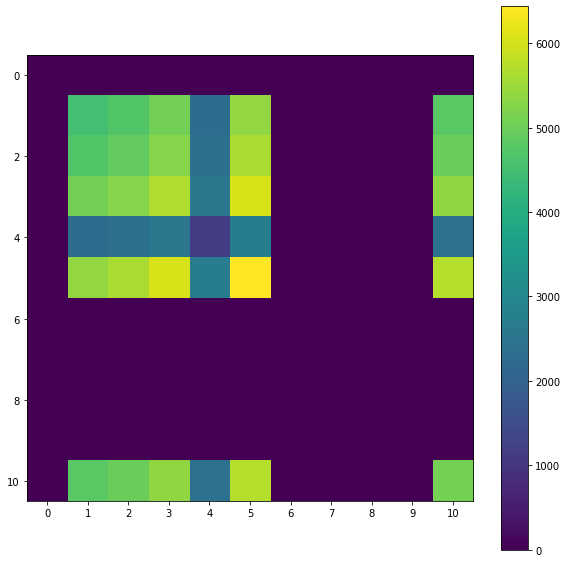

In [260]:
plt.figure(figsize=(10, 10))
plt.imshow(gram.detach())
#plt.yticks([idx for idx in range(len(gram))], [labels[idx].split(": ")[-1] for idx in range(len(gram))])
#plt.yticks([idx for idx in range(len(gram))], [real_labels[idx].split(" ")[-1] for idx in range(len(gram))])
plt.xticks([idx for idx in range(len(gram))], [idx for idx in range(len(gram))])
plt.colorbar()

In [262]:
import numpy as np

Text(0.5, 1.0, 'Eigenvalues after removing largest')

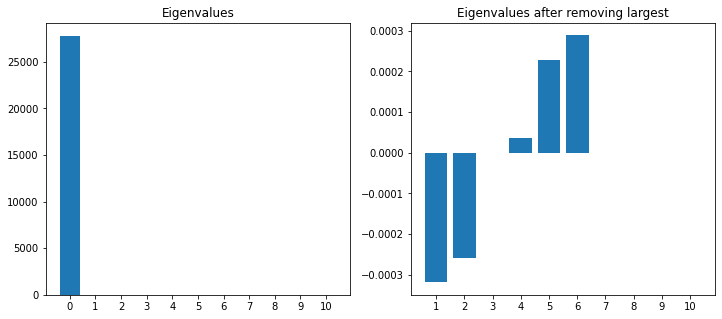

In [264]:
eig_vals, eig_vecs = np.linalg.eig(gram.detach())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar([idx for idx in range(len(eig_vals))], eig_vals)
axs[0].set_xticks([idx for idx in range(len(eig_vals))], [idx for idx in range(len(eig_vals))])
axs[0].set_title("Eigenvalues")

axs[1].bar([idx for idx in range(1, len(eig_vals))], eig_vals[1:])
axs[1].set_xticks([idx for idx in range(1, len(eig_vals))], [idx for idx in range(1, len(eig_vals))])
axs[1].set_title("Eigenvalues after removing largest")

In [270]:
index_to_class = {0: 'H', 1: 'C', 2: 'N', 3: 'O', 4: 'F', 5: 'Atomic #', 6: 'Accept', 7: 'Doner', 8: 'Aromatic', 9: 'sp', 10: 'number of H'
}

Text(0.5, 1.0, 'Top Eigenvector')

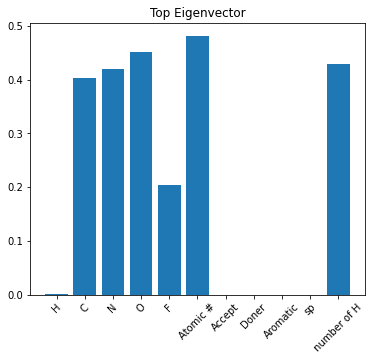

In [272]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
axs.bar([idx for idx in range(len(eig_vecs[:, 0]))], eig_vecs[:, 0])
axs.set_xticks([idx for idx in range(len(eig_vecs[:, 0]))], [index_to_class[idx] for idx in range(len(eig_vecs[:, 0]))], rotation=45)
axs.set_title("Top Eigenvector")

In [64]:
lbs = [real_labels[idx].split(" ")[-1] for idx in range(len(gram))]

In [44]:
import numpy as np

In [112]:
eig_vals, eig_vecs = np.linalg.eig(gram)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, '0: C'),
  Text(1, 0, '1: C'),
  Text(2, 0, '2: C'),
  Text(3, 0, '3: C'),
  Text(4, 0, '4: C'),
  Text(5, 0, '5: O'),
  Text(6, 0, '6: H'),
  Text(7, 0, '7: H'),
  Text(8, 0, '8: H'),
  Text(9, 0, '9: H'),
  Text(10, 0, '10: H'),
  Text(11, 0, '11: H'),
  Text(12, 0, '12: H'),
  Text(13, 0, '13: H'),
  Text(14, 0, '14: H'),
  Text(15, 0, '15: H'),
  Text(16, 0, '16: H'),
  Text(17, 0, '17: H')])

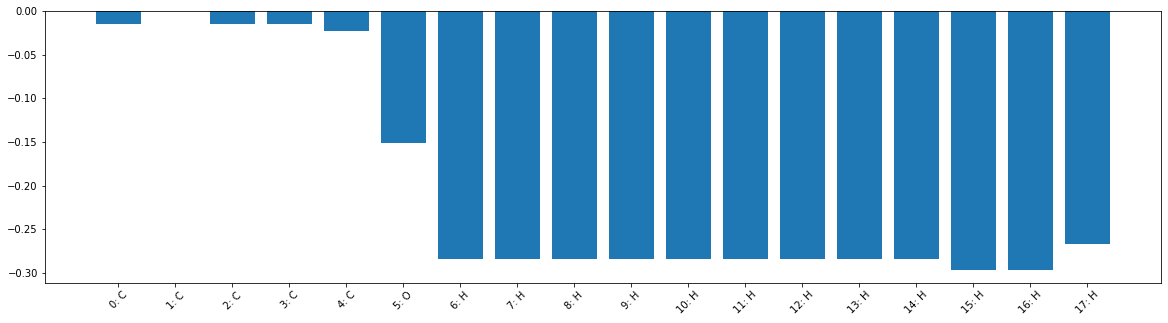

In [118]:
plt.figure(figsize=(20, 5))
plt.bar(labels.values(), eig_vecs[:, 0])
plt.xticks(rotation=45)

In [119]:
np.save("qm9_nn_eigvals.npy", eig_vals)
np.save("qm9_nn_eigvecs.npy", eig_vecs)

In [145]:
np.save("qm9_nn_jac.npy", jac.flatten().detach().numpy())

In [139]:
np.save("qm9_dd_jac.npy", sum_jac.flatten().detach().numpy())

In [163]:
np.save("arxiv_nn_jac.npy", jac.flatten().detach().numpy())

In [177]:
np.save("arxiv_dd_jac.npy", sum_jac.flatten().detach().numpy())

In [140]:
for data in dataset:
    if 'O' in data.smiles:
        if data.x.shape[0] >= 18:
            break

In [173]:
import networkx as nx

In [174]:
from torch_geometric.utils import to_dense_adj

In [193]:
adj = to_dense_adj(sub_data.edge_index.cpu()).numpy()

In [194]:
adj = adj[0]

In [110]:
labels = {}

for i in range(0, 5):
    labels[i] = f'{i}: C'
    
for i in range(5, 6):
    labels[i] = f'{i}: O'
    
for i in range(6, len(data.x)):
    labels[i] = f'{i}: H'

# for idx in range(len(sub_data.y)):
#     label = sub_data.y[idx].item()
#     labels[idx] = label

In [59]:
label_to_subject_area = {
    0: "Computer Science (cs.AI)",
    1: "Computer Science (cs.AR)",
    2: "Computer Science (cs.CC)",
    3: "Computer Science (cs.CE)",
    4: "Computer Science (cs.CG)",
    5: "Computer Science (cs.CL)",
    6: "Computer Science (cs.CR)",
    7: "Computer Science (cs.CV)",
    8: "Computer Science (cs.CY)",
    9: "Computer Science (cs.DB)",
    10: "Computer Science (cs.DC)",
    11: "Computer Science (cs.DL)",
    12: "Computer Science (cs.DM)",
    13: "Computer Science (cs.DS)",
    14: "Computer Science (cs.ET)",
    15: "Computer Science (cs.FL)",
    16: "Computer Science (cs.GL)",
    17: "Computer Science (cs.GR)",
    18: "Computer Science (cs.GT)",
    19: "Computer Science (cs.HC)",
    20: "Computer Science (cs.IR)",
    21: "Computer Science (cs.IT)",
    22: "Computer Science (cs.LG)",
    23: "Computer Science (cs.LO)",
    24: "Computer Science (cs.MA)",
    25: "Computer Science (cs.MM)",
    26: "Computer Science (cs.MS)",
    27: "Computer Science (cs.NA)",
    28: "Computer Science (cs.NE)",
    29: "Computer Science (cs.NI)",
    30: "Computer Science (cs.OH)",
    31: "Computer Science (cs.OS)",
    32: "Computer Science (cs.PF)",
    33: "Computer Science (cs.PL)",
    34: "Computer Science (cs.RO)",
    35: "Computer Science (cs.SC)",
    36: "Computer Science (cs.SD)",
    37: "Computer Science (cs.SE)",
    38: "Computer Science (cs.SI)",
    39: "Computer Science (cs.SY)"
}


In [60]:
import pandas as pd

In [61]:
real_labels = {key: str(key) + " " + label_to_subject_area[item].split('.')[-1][:-1] for key, item in labels.items()}

In [206]:
graph = nx.Graph(adj)

In [207]:
edges = graph.edges()

In [212]:
colors = [abs(gram[u][v]) for u, v in edges]
widths = [abs(gram[u][v])/5 for u, v in edges]
node_colors = [abs(gram[v][v]) for v in range(len(sub_data.y))]

In [218]:
sub_data.input_id

tensor([245])

In [224]:
import pandas as pd

In [225]:
df = pd.read_csv("dataset/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz")

In [229]:
y = model(data.x, data.edge_index)

In [230]:
y[245]

tensor([-2.4761, -0.1790, -2.1617,  3.2634, -0.3752,  7.5534,  1.6618,  0.4023,
         1.2348, -4.3049,  2.8703,  0.8766, -4.6297,  2.1880, -4.1960,  1.4314,
         0.8284, -1.6538, -3.5172,  1.0252, -4.5889,  1.9982, -0.2140,  5.6806,
         3.6407, -4.9843, -1.8899,  1.0740, -1.7361,  1.8460, -1.9567, -0.5138,
         0.4328, -6.1567, -1.1391,  0.0580, -1.3686,  3.3910, -2.8511, -5.2253],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [220]:
data.y[245]

tensor([5], device='cuda:0')

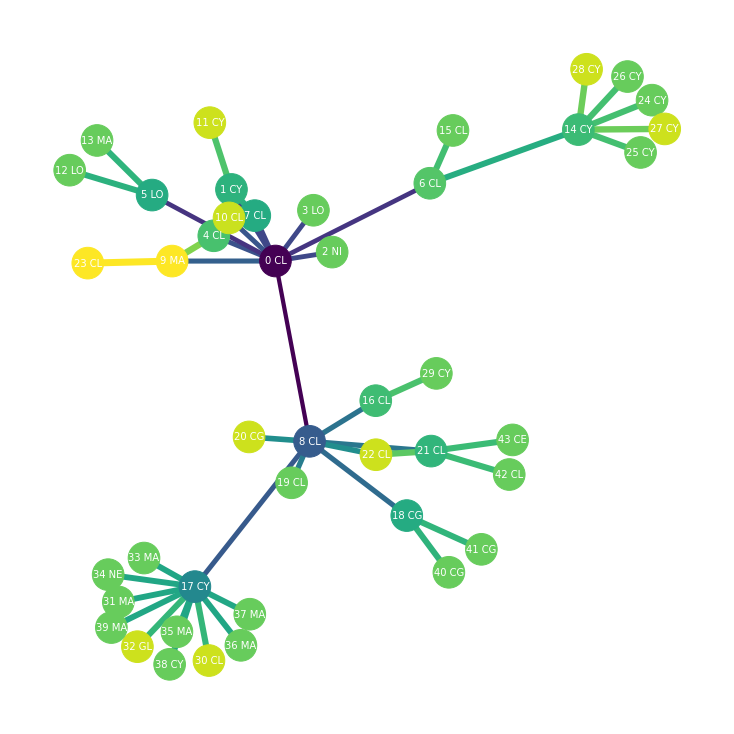

In [214]:
plt.figure(figsize=(10, 10))
nx.draw(graph, with_labels=True, labels=real_labels, font_size=10, font_color="white", node_size=1000, edge_color=colors, width=widths, node_color=node_colors)

In [66]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(gram_np)

pca = PCA()
pca_result = pca.fit_transform(gram_np)

In [245]:
for name, param in model.conv1.named_parameters():
    if name == "lin.weight":
        weight = param

In [246]:
comp_gram = weight.T @ weight

In [287]:
def normalize_adjacency_matrix(A):
    # Add self-loops
    N = A.shape[0]
    A_hat = A + torch.eye(N)

    # Degree matrix
    D = torch.diag(torch.sum(A_hat, dim=1))

    # Inverse square root of the degree matrix
    D_inv_sqrt = torch.diag(torch.pow(torch.sum(A_hat, dim=1), -0.5))
    
    # Normalized adjacency matrix
    A_normalized = D_inv_sqrt @ A_hat @ D_inv_sqrt
    
    return A_normalized

In [274]:
adj = torch.tensor(adj)

In [288]:
adj = normalize_adjacency_matrix(adj)

In [300]:
sum_W = torch.zeros(sub_data.x.shape[0], weight.shape[0])

for input_dim in range(weight.shape[1]):
    W = torch.zeros(sub_data.x.shape[0], weight.shape[0])
    for output_dim in range(weight.shape[0]): #number of hidden dim
        val_assign = weight[output_dim][input_dim]
        W[:, output_dim] = val_assign
    
    W_til = adj @ W
    sum_W += W_til

In [304]:
sum_W.shape

torch.Size([45, 256])

In [305]:
comp_gram = sum_W @ sum_W.T

In [306]:
sum_W.shape

torch.Size([45, 256])

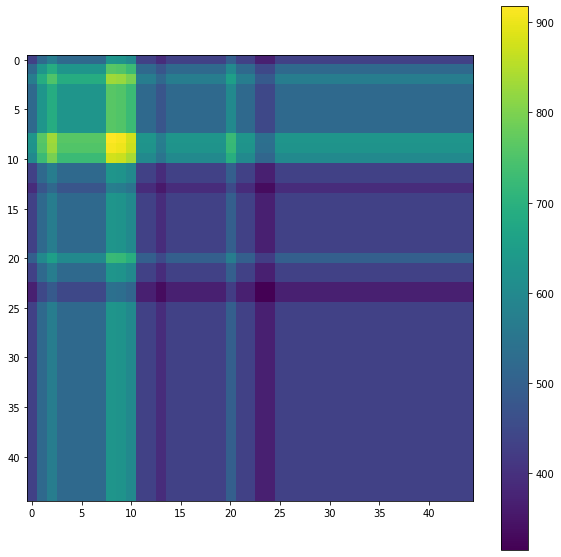

In [307]:
plt.figure(figsize=(10, 10))
plt.imshow(comp_gram.detach())
plt.colorbar()

In [139]:
from torch.linalg import norm

In [140]:
def correlate(M, G):
    M = M.double()
    G = G.double()
    normM = norm(M.flatten())
    normG = norm(G.flatten())

    corr = torch.dot(M.flatten(), G.flatten()) / (normM * normG)
    return corr

In [141]:
correlate(gram.detach(), comp_gram.detach())

tensor(0.9839, dtype=torch.float64)